In [535]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from io import StringIO
import subprocess
import numpy as np
from lxml import html
import seaborn as sns; sns.set()

page=requests.get('http://www.espn.com/nba/salaries/_/year/2018')

In [467]:
def getPageContent(pageText):
    soup = BeautifulSoup(pageText)
    content = soup.find("div")
    players = content.find_all('tr', attrs={'class':'oddrow'})
    players2 = content.find_all('tr', attrs={'class':'evenrow'})
    data = []
    for i in range(len(players)):
        rowText = [ t.text for t in players[i].find_all('td') ]
        data.append(rowText)
    for i in range(len(players2)):
        rowText = [ t.text for t in players2[i].find_all('td') ]
        data.append(rowText)
    name = [ i[1] for i in data]
    team = [ i[2] for i in data]
    salary = [ i[3] for i in data]
    rdf = pd.DataFrame({
    'name': name,
    'team': team,
    'salary': salary
    })
    
    return rdf

In [468]:
def scrapeNbaYear(year):
    url = 'http://www.espn.com/nba/salaries/_/year/{}'.format(str(year))
    
    start_page = requests.get(url)
    pages = BeautifulSoup(start_page.text).find('div',{'class':"page-numbers"}).text.split(" of ")[-1]
    
    rdf = getPageContent(start_page.text)
    for page in range(2,int(pages)+1):
        url = 'http://www.espn.com/nba/salaries/_/year/{}/page/{}'.format(str(year),str(page))
        rdf = pd.concat([rdf, getPageContent(requests.get(url).text)])
        rdf['year'] = year
    return rdf
    

In [469]:
salaries = pd.concat([scrapeNbaYear(2018),scrapeNbaYear(2017)])

/usr/local/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /usr/local/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [470]:
salaries_DF = salaries
# seperate position from name
salaries_DF['position'] = [i[-1] for i in salaries_DF.name.str.split(",")]
salaries_DF['name'] = [i[0] for i in salaries_DF.name.str.split(",")]

# remove spaces
salaries_DF.name = salaries_DF.name.str.strip()
salaries_DF.position = salaries_DF.position.str.strip()
salaries_DF.team = salaries_DF.team.str.strip()

# clean salary
salaries_DF.salary = salaries_DF.salary.str.replace("$","")
salaries_DF.salary = salaries_DF.salary.str.replace(",","")
salaries_DF.salary = salaries_DF.salary.astype(int)

In [471]:
df = pd.read_csv('NBA_player_of_the_week.csv')
df.columns = df.columns.str.replace(' ', '')
bball = df[df.Seasonshort > 2016]

In [472]:
for column in salaries_DF.columns.values.tolist():
    bball["salary_{}".format(column)] = 'null'

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [473]:
for row in range(len(bball)):
    if row % 10 == 0:
        print(row)
    player = bball['Player'].values[row]
    year = bball['Seasonshort'].values[row]
    team = bball['Team'].values[row]
    playerDF = salaries_DF[salaries_DF['name'] == player]
    yearDF = playerDF[playerDF['year'] == year]
#     teamDF = yearDF[yearDF['team'] == team]
    if len(yearDF) != 0:
        bball.iat[row, bball.columns.values.tolist().index('salary_name')] = yearDF.name.values[0]
        bball.iat[row, bball.columns.values.tolist().index('salary_salary')] = yearDF.salary.values[0]
        bball.iat[row, bball.columns.values.tolist().index('salary_team')] = yearDF.team.values[0]
        bball.iat[row, bball.columns.values.tolist().index('salary_year')] = yearDF.year.values[0]
        bball.iat[row, bball.columns.values.tolist().index('salary_position')] = yearDF.position.values[0]
    else:
        pass

0
10
20
30
40
50
60
70
80


In [474]:
bball

,Age,Conference,Date,DraftYear,Height,Player,Position,Season,Seasonshort,Seasonsinleague,Team,Weight,Real_value,salary_name,salary_salary,salary_team,salary_year,salary_position
1055,26,East,"Apr 10, 2017",2010,206cm,Paul George,GF,2016-2017,2017,6,Indiana Pacers,100kg,0.5,Paul George,18314532,Indiana Pacers,2017,SF
1056,28,West,"Apr 10, 2017",2008,191cm,Russell Westbrook,G,2016-2017,2017,8,Oklahoma City Thunder,91kg,0.5,null,null,null,null,null
1057,27,East,"Apr 3, 2017",2011,201cm,Jimmy Butler,GF,2016-2017,2017,5,Chicago Bulls,105kg,0.5,Jimmy Butler,17552209,Chicago Bulls,2017,SG
1058,28,West,"Apr 3, 2017",2009,191cm,Stephen Curry,G,2016-2017,2017,7,Golden State Warriors,86kg,0.5,Stephen Curry,12112359,Golden State Warriors,2017,PG
1059,27,East,"Mar 27, 2017",2009,201cm,DeMar DeRozan,GF,2016-2017,2017,7,Toronto Raptors,100kg,0.5,null,null,null,null,null
1060,27,West,"Mar 27, 2017",2009,196cm,James Harden,SG,2016-2017,2017,7,Houston Rockets,100kg,0.5,null,null,null,null,null
1061,27,East,"Mar 20, 2017",2010,213cm,Hassan Whiteside,C,2016-2017,2017,4,Miami Heat,120kg,0.5,null,null,null,null,null
1062,26,West,"Mar 20, 2017",2012,191cm,Damian Lillard,G,2016-2017,2017,4,Portland Trail Blazers,88kg,0.5,Damian Lillard,24328425,Portland Trail Blazers,2017,PG
1063,26,East,"Mar 13, 2017",2010,193cm,John Wall,PG,2016-2017,2017,6,Washington Wizards,95kg,0.5,John Wall,16957900,Washington Wizards,2017,PG
1064,21,West,"Mar 13, 2017",2015,213cm,Karl-Anthony Towns,C,2016-2017,2017,1,Minnesota Timberwolves,111kg,0.5,Karl-Anthony Towns,5960160,Minnesota Timberwolves,2017,C


In [475]:
bball.iat[4,13]

'null'

In [476]:
dfcount = bball.groupby(['Player'])['Real_value'].sum()
dfcount

Player
Andre Drummond           0.5
Anthony Davis            1.5
Ben Simmons              0.5
Blake Griffin            0.5
Bradley Beal             0.5
Chris Paul               0.5
Damian Lillard           2.0
DeMar DeRozan            4.5
DeMarcus Cousins         1.0
Dion Waiters             0.5
George Hill              0.5
Giannis Antetokounmpo    1.0
Goran Dragic             1.0
Gordon Hayward           0.5
Hassan Whiteside         0.5
Isaiah Thomas            1.0
James Harden             4.5
Jimmy Butler             1.5
Joel Embiid              1.5
John Wall                1.0
Karl-Anthony Towns       1.0
Kawhi Leonard            1.0
Kemba Walker             0.5
Kevin Durant             1.0
Kevin Love               0.5
Khris Middleton          0.5
Kristaps Porzingis       0.5
LaMarcus Aldridge        0.5
LeBron James             4.0
Lou Williams             1.0
Marc Gasol               0.5
Nikola Jokic             1.0
Paul George              0.5
Russell Westbrook        3.0
Stephen

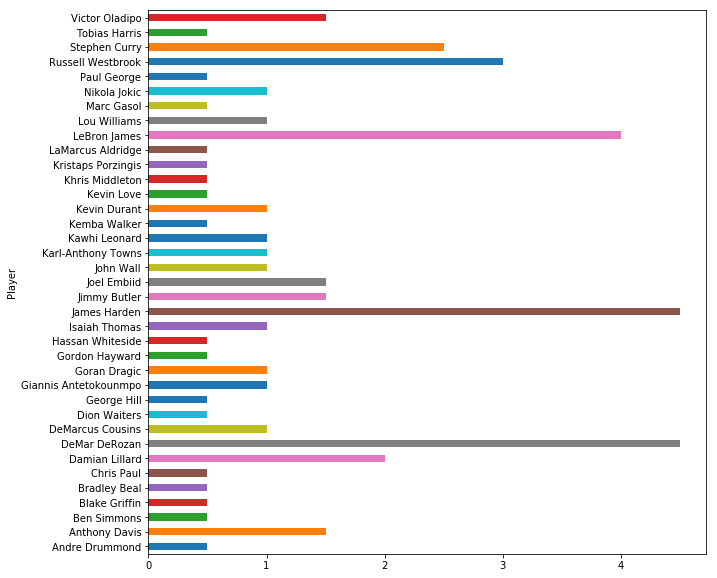

In [477]:
dfcount.plot(kind='barh',width=.5, figsize=(10,10))

In [478]:
bball

,Age,Conference,Date,DraftYear,Height,Player,Position,Season,Seasonshort,Seasonsinleague,Team,Weight,Real_value,salary_name,salary_salary,salary_team,salary_year,salary_position
1055,26,East,"Apr 10, 2017",2010,206cm,Paul George,GF,2016-2017,2017,6,Indiana Pacers,100kg,0.5,Paul George,18314532,Indiana Pacers,2017,SF
1056,28,West,"Apr 10, 2017",2008,191cm,Russell Westbrook,G,2016-2017,2017,8,Oklahoma City Thunder,91kg,0.5,null,null,null,null,null
1057,27,East,"Apr 3, 2017",2011,201cm,Jimmy Butler,GF,2016-2017,2017,5,Chicago Bulls,105kg,0.5,Jimmy Butler,17552209,Chicago Bulls,2017,SG
1058,28,West,"Apr 3, 2017",2009,191cm,Stephen Curry,G,2016-2017,2017,7,Golden State Warriors,86kg,0.5,Stephen Curry,12112359,Golden State Warriors,2017,PG
1059,27,East,"Mar 27, 2017",2009,201cm,DeMar DeRozan,GF,2016-2017,2017,7,Toronto Raptors,100kg,0.5,null,null,null,null,null
1060,27,West,"Mar 27, 2017",2009,196cm,James Harden,SG,2016-2017,2017,7,Houston Rockets,100kg,0.5,null,null,null,null,null
1061,27,East,"Mar 20, 2017",2010,213cm,Hassan Whiteside,C,2016-2017,2017,4,Miami Heat,120kg,0.5,null,null,null,null,null
1062,26,West,"Mar 20, 2017",2012,191cm,Damian Lillard,G,2016-2017,2017,4,Portland Trail Blazers,88kg,0.5,Damian Lillard,24328425,Portland Trail Blazers,2017,PG
1063,26,East,"Mar 13, 2017",2010,193cm,John Wall,PG,2016-2017,2017,6,Washington Wizards,95kg,0.5,John Wall,16957900,Washington Wizards,2017,PG
1064,21,West,"Mar 13, 2017",2015,213cm,Karl-Anthony Towns,C,2016-2017,2017,1,Minnesota Timberwolves,111kg,0.5,Karl-Anthony Towns,5960160,Minnesota Timberwolves,2017,C


In [479]:
bball['salary_salary'] = [ np.nan if x =='null' else x for x in bball['salary_salary'].values ]

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [480]:
bball['salary_salary'] = bball['salary_salary'].astype(float)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [506]:
playsal = bball.groupby(["Player",]).sum()

In [507]:
playsal

,Age,DraftYear,Seasonshort,Seasonsinleague,Real_value,salary_salary
Player,,,,,,
Andre Drummond,24,2012,2018,5,0.5,25434263.0
Anthony Davis,71,6036,6053,14,1.5,69667762.0
Ben Simmons,21,2016,2018,1,0.5,6434520.0
Blake Griffin,27,2009,2017,7,0.5,20140839.0
Bradley Beal,24,2012,2018,5,0.5,25434263.0
Chris Paul,32,2005,2018,12,0.5,24599495.0
Damian Lillard,107,8048,8071,19,2.0,102787596.0
DeMar DeRozan,248,18081,18158,68,4.5,138699875.0
DeMarcus Cousins,53,4020,4035,13,1.0,35021750.0


In [707]:
dfg = bball.groupby(['Team', 'Player']).agg({'Real_value':'count', 'Seasonshort':'max', 'salary_salary':'max','salary_position':'max','Seasonsinleague':'max', 'Height':'max'}).reset_index()

In [708]:
dfg.sort_values(by='Real_value', ascending=False)

,Team,Player,Real_value,salary_position,Seasonsinleague,Height,salary_salary,Seasonshort
33,Toronto Raptors,DeMar DeRozan,9,null,8,201cm,27739975.0,2018
11,Houston Rockets,James Harden,9,null,8,196cm,28299399.0,2018
4,Cleveland Cavaliers,LeBron James,8,null,14,203cm,30963450.0,2018
26,Oklahoma City Thunder,Russell Westbrook,6,null,9,191cm,28530608.0,2018
9,Golden State Warriors,Stephen Curry,5,PG,8,191cm,37457154.0,2018
29,Portland Trail Blazers,Damian Lillard,4,PG,5,191cm,26153057.0,2018
2,Chicago Bulls,Jimmy Butler,3,SG,5,201cm,17552209.0,2017
28,Philadelphia Sixers,Joel Embiid,3,C,3,213cm,25250000.0,2018
23,New Orleans Pelicans,Anthony Davis,3,PF,5,208cm,23775506.0,2018
13,Indiana Pacers,Victor Oladipo,3,SG,4,193cm,21000000.0,2018


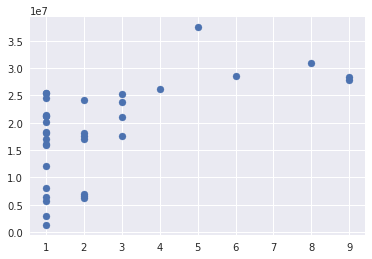

In [499]:
plt.scatter('Real_value', 'salary_salary', data=dfg)
plt.show()

In [699]:
dfg2 = bball.groupby(['salary_position']).agg({'Real_value':'count', 'Seasonshort':'max', 'salary_salary':'mean','Seasonsinleague':'mean'}).reset_index()

In [700]:
dfg3 = dfg2[np.isfinite(dfg2.salary_salary)]

In [701]:
dfg3

,salary_position,Real_value,salary_salary,Seasonsinleague,Seasonshort
0,C,9,1.656943e+07,4.111111,2018
1,PF,9,1.836501e+07,5.444444,2018
2,PG,26,2.103614e+07,6.923077,2018
3,SF,10,2.108176e+07,8.500000,2018
4,SG,15,1.977925e+07,6.666667,2018


In [551]:
dfg3.salary_position = dfg3.salary_position.astype('category')

/usr/local/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


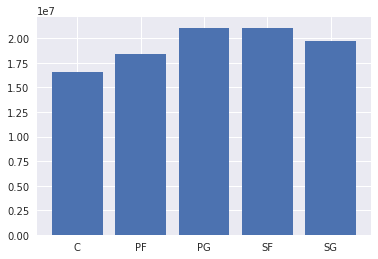

In [552]:
fig,axs = plt.subplots()
axs.bar(dfg3.salary_position, dfg3.salary_salary)
plt.show()

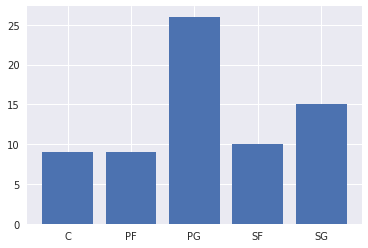

In [538]:
fig,axs = plt.subplots()
axs.bar(dfg3.salary_position, dfg3.Real_value)
plt.show()

In [581]:
dfg4 = bball.groupby(['Player','salary_position']).agg({'Real_value':'count', 'Seasonshort':'max', 'salary_salary':'max','Height':'max'}).reset_index()

In [582]:
dfg5 = dfg4[np.isfinite(dfg4.salary_salary)]

In [583]:
dfg5

,Player,salary_position,Real_value,Height,salary_salary,Seasonshort
0,Andre Drummond,C,1,211cm,25434263.0,2018
1,Anthony Davis,PF,3,208cm,23775506.0,2018
2,Ben Simmons,PG,1,208cm,6434520.0,2018
3,Blake Griffin,PF,1,208cm,20140839.0,2017
4,Bradley Beal,SG,1,196cm,25434263.0,2018
5,Chris Paul,PG,1,183cm,24599495.0,2018
6,Damian Lillard,PG,4,191cm,26153057.0,2018
7,DeMar DeRozan,SG,5,201cm,27739975.0,2018
9,DeMarcus Cousins,C,2,211cm,18063850.0,2018
10,Dion Waiters,SG,1,193cm,2898000.0,2017


In [704]:
dfg6 = dfg5.sort_values('Real_value',ascending=True)

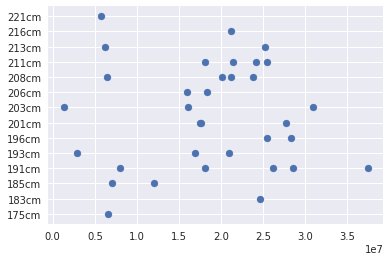

In [575]:
plt.scatter('salary_salary', 'Height', data=dfg6)
plt.show()

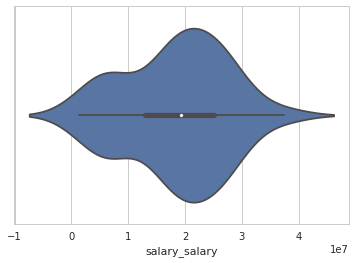

In [588]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=dfg6["salary_salary"])

In [590]:
dfg["salary_salary"].mean()

18415085.34285714

In [606]:
toppaid = dfg[['Player', 'salary_salary']].sort_values('salary_salary',ascending=False).head()

In [607]:
toppaid

,Player,salary_salary
9,Stephen Curry,37457154.0
4,LeBron James,30963450.0
26,Russell Westbrook,28530608.0
11,James Harden,28299399.0
33,DeMar DeRozan,27739975.0


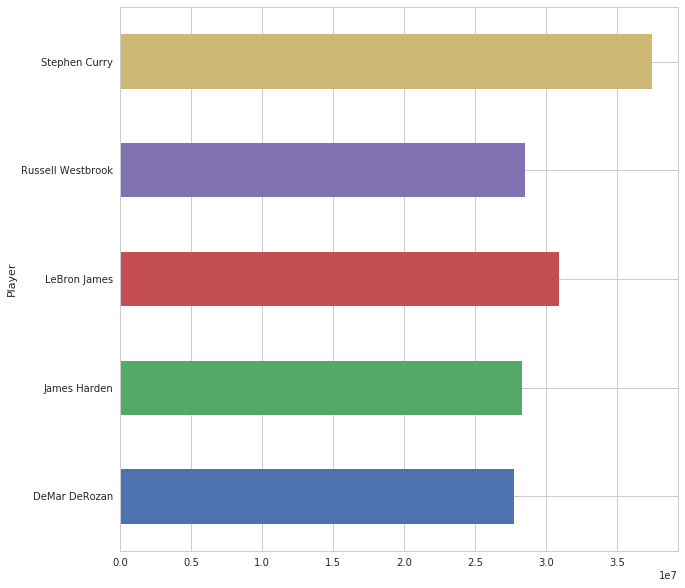

In [674]:
toppaid1.plot(kind='barh',width=.5, figsize=(10,10))

In [649]:
toppaid1 = toppaid.groupby(['Player'])['salary_salary'].max().head()

In [650]:
toppaid1

Player
DeMar DeRozan        27739975.0
James Harden         28299399.0
LeBron James         30963450.0
Russell Westbrook    28530608.0
Stephen Curry        37457154.0
Name: salary_salary, dtype: float64

In [ ]:
toppaid.plot(kind='barh',width=.5, figsize=(10,10))

In [659]:
teams = bball.groupby(['Team']).agg({'Real_value':'count', 'Seasonshort':'max', 'salary_salary':'sum'}).reset_index()

In [665]:
teamssort = teams.sort_values('Real_value', ascending=False).head()

In [666]:
teamssort

,Team,Real_value,salary_salary,Seasonshort
7,Houston Rockets,10,166096490.0,2018
21,Toronto Raptors,9,138699875.0,2018
3,Cleveland Cavaliers,9,145019475.0,2018
6,Golden State Warriors,7,111251385.0,2018
16,Oklahoma City Thunder,6,57061216.0,2018


In [668]:
teamsuccess = teamssort[["Team", 'Real_value']]

In [669]:
teamsuccess

,Team,Real_value
7,Houston Rockets,10
21,Toronto Raptors,9
3,Cleveland Cavaliers,9
6,Golden State Warriors,7
16,Oklahoma City Thunder,6


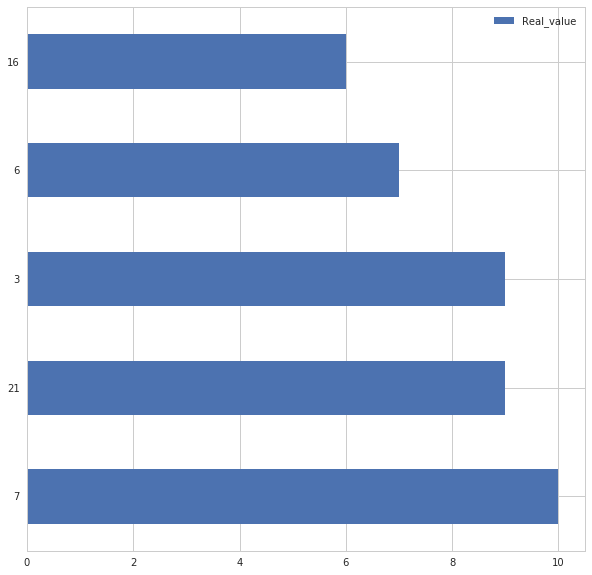

In [670]:
teamsuccess.plot(kind='barh',width=.5, figsize=(10,10))

In [671]:
teamsucc = bball.groupby(['Team'])['Real_value'].sum()


In [672]:
teamsucc

Team
Boston Celtics            1.0
Charlotte Hornets         0.5
Chicago Bulls             1.5
Cleveland Cavaliers       4.5
Denver Nuggets            1.0
Detroit Pistons           1.0
Golden State Warriors     3.5
Houston Rockets           5.0
Indiana Pacers            2.0
Los Angeles Clippers      1.5
Memphis Grizzlies         0.5
Miami Heat                2.0
Milwaukee Bucks           1.5
Minnesota Timberwolves    1.0
New Orleans Pelicans      2.0
New York Knicks           0.5
Oklahoma City Thunder     3.0
Philadelphia Sixers       2.0
Portland Trail Blazers    2.0
Sacramento Kings          0.5
San Antonio Spurs         1.5
Toronto Raptors           4.5
Utah Jazz                 1.0
Washington Wizards        1.5
Name: Real_value, dtype: float64

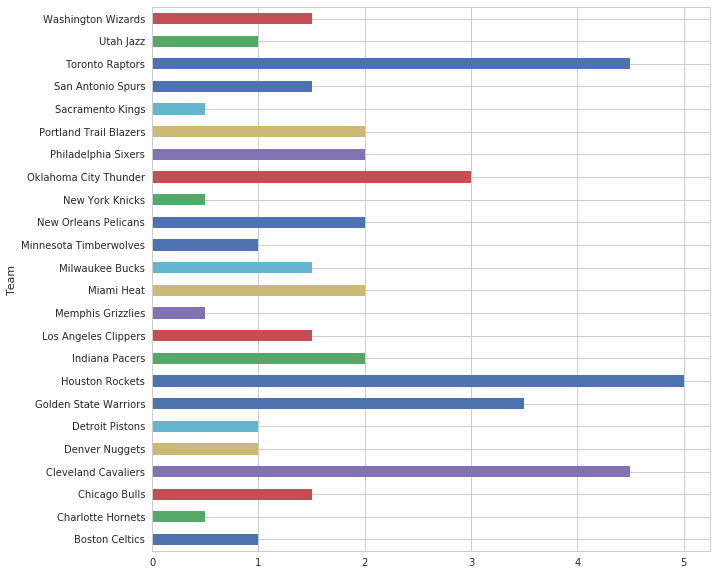

In [673]:
teamsucc.plot(kind='barh',width=.5, figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ff4838fd0>]],
      dtype=object)

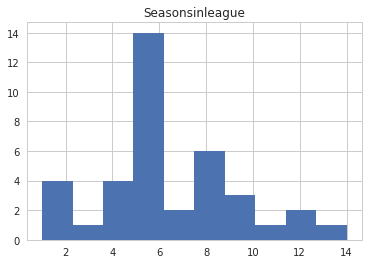

In [686]:
dfg.hist(column='Seasonsinleague')


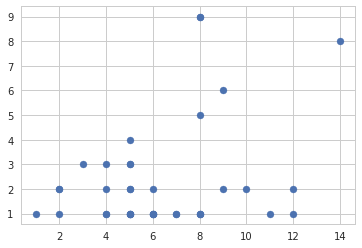

In [687]:
plt.scatter('Seasonsinleague', 'Real_value', data=dfg)

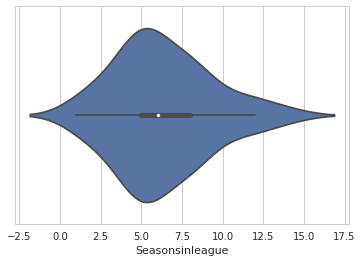

In [688]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=dfg["Seasonsinleague"])

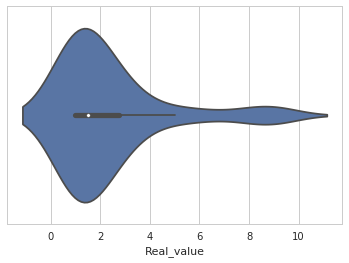

In [691]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=dfg["Real_value"])

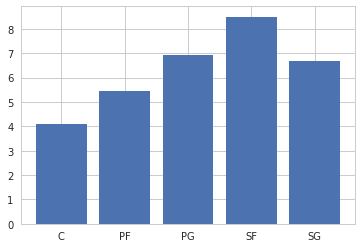

In [702]:
fig,axs = plt.subplots()
axs.bar(dfg3.salary_position, dfg3.Seasonsinleague)
plt.show()

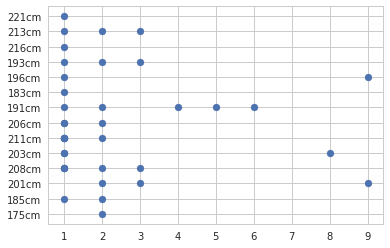

In [709]:
plt.scatter('Real_value', 'Height', data=dfg)
plt.show()